# Installation & Imports

In [ ]:
!pip install gdown

In [ ]:
import gdown
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import RFE
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score
from sklearn import metrics
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
file_id = "1jEIJbMVmYRKu7nnTyyTB_lmxRzyfoy56"
dataset = "accidents_dataset.csv"
gdown.download(f"https://drive.google.com/uc?id={file_id}", dataset, quiet=False)

original_dataset = pd.read_csv(dataset)
print(original_dataset.info())

Downloading...
From: https://drive.google.com/uc?id=1jEIJbMVmYRKu7nnTyyTB_lmxRzyfoy56
To: /content/accidents_dataset.csv
100%|██████████| 4.30M/4.30M [00:00<00:00, 21.4MB/s]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12316 entries, 0 to 12315
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         12316 non-null  object
 1   Day_of_week                  12316 non-null  object
 2   Age_band_of_driver           12316 non-null  object
 3   Sex_of_driver                12316 non-null  object
 4   Educational_level            11575 non-null  object
 5   Vehicle_driver_relation      11737 non-null  object
 6   Driving_experience           11487 non-null  object
 7   Type_of_vehicle              11366 non-null  object
 8   Owner_of_vehicle             11834 non-null  object
 9   Service_year_of_vehicle      8388 non-null   object
 10  Defect_of_vehicle            7889 non-null   object
 11  Area_accident_occured        12077 non-null  object
 12  Lanes_or_Medians             11931 non-null  object
 13  Road_allignment              12

# Data Cleaning/Preprocessing

In [ ]:
#Replace 'na' with NaN
original_dataset.replace('na', np.nan, inplace=True)

numerical_columns = ["Number_of_vehicles_involved", "Number_of_casualties", "Casualty_severity"]
label_encoder = LabelEncoder()

#Apply label encoding to each column
for column in original_dataset.columns:
    if column not in numerical_columns:
        original_dataset[column] = label_encoder.fit_transform(original_dataset[column])

#Split the dataset into their own class
class_0 = original_dataset[original_dataset['Accident_severity'] == 0]
class_1 = original_dataset[original_dataset['Accident_severity'] == 1]
class_2 = original_dataset[original_dataset['Accident_severity'] == 2]

#Drop all the row with missing value in class 2 (slight severity)
class_2_drop = class_2.dropna()

#Create an imputer that replace the missing values with most frequent
imputer = SimpleImputer(strategy='most_frequent')

#Drop the target column in class 0 and 1 before imputing
class_0 = class_0.drop(columns=['Accident_severity'])
class_1 = class_1.drop(columns=['Accident_severity'])

#Apply imputer to class 0 and 1
class_0_imputed = pd.DataFrame(imputer.fit_transform(class_0), columns=class_0.columns)
class_1_imputed = pd.DataFrame(imputer.fit_transform(class_1), columns=class_1.columns)

#Add back the target column
class_0_imputed['Accident_severity'] = 0
class_1_imputed['Accident_severity'] = 1

#Combine the classes and shuffle it
cleaned_dataset = pd.concat([class_0_imputed, class_1_imputed, class_2_drop])
cleaned_dataset = cleaned_dataset.sample(frac=1, random_state=46).reset_index(drop=True)

print(cleaned_dataset.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8535 entries, 0 to 8534
Data columns (total 32 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   Time                         8535 non-null   object
 1   Day_of_week                  8535 non-null   object
 2   Age_band_of_driver           8535 non-null   object
 3   Sex_of_driver                8535 non-null   object
 4   Educational_level            8535 non-null   object
 5   Vehicle_driver_relation      8535 non-null   object
 6   Driving_experience           8535 non-null   object
 7   Type_of_vehicle              8535 non-null   object
 8   Owner_of_vehicle             8535 non-null   object
 9   Service_year_of_vehicle      8535 non-null   object
 10  Defect_of_vehicle            8535 non-null   object
 11  Area_accident_occured        8535 non-null   object
 12  Lanes_or_Medians             8535 non-null   object
 13  Road_allignment              8535

# Feature Reduction

In [ ]:
#Assign training and testing columns
target_col = 'Accident_severity'
y = cleaned_dataset[target_col]
X = cleaned_dataset.drop(columns=[target_col])

#Assign training and testing data (80% train, 20% test)
x_train, x_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=46)

#Using RFE and Random Forest for feature selection
rfe_selector = RFE(estimator=RandomForestClassifier(n_estimators=100, random_state=46), n_features_to_select=28, step=1)
rfe_selector.fit(x_train, y_train)

# Get selected features
selected_features = x_train.columns[rfe_selector.support_]
print("\nSelected Features:")
print(selected_features)

x_train = x_train[selected_features]
x_test = x_test[selected_features]


Selected Features:
Index(['Time', 'Day_of_week', 'Age_band_of_driver', 'Educational_level',
       'Vehicle_driver_relation', 'Driving_experience', 'Type_of_vehicle',
       'Owner_of_vehicle', 'Service_year_of_vehicle', 'Defect_of_vehicle',
       'Area_accident_occured', 'Lanes_or_Medians', 'Road_allignment',
       'Types_of_Junction', 'Road_surface_conditions', 'Light_conditions',
       'Weather_conditions', 'Type_of_collision',
       'Number_of_vehicles_involved', 'Number_of_casualties',
       'Vehicle_movement', 'Casualty_class', 'Sex_of_casualty',
       'Age_band_of_casualty', 'Work_of_casuality', 'Fitness_of_casuality',
       'Pedestrian_movement', 'Cause_of_accident'],
      dtype='object')


# Model

### Grid Search

In [ ]:
model = RandomForestClassifier(class_weight='balanced', random_state=46)
grid = {
   'n_estimators': [100, 200, 300],
   'max_depth': [10, 20, 30, None],
   'min_samples_split': [2, 5, 10],
   'min_samples_leaf': [1, 2, 4],
   'max_features': ['sqrt', 'log2']
}
grid_search = GridSearchCV(
   estimator=model,
   param_grid=grid,
   cv=3,
   scoring='f1_macro',
   n_jobs=-1,
   verbose=1
)
grid_search.fit(x_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Fitting 3 folds for each of 216 candidates, totalling 648 fits
Best parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 200}
Best score: 0.5173421407680902


In [ ]:
best_model = grid_search.best_estimator_

Accuracy: 0.8529584065612185
F1 Score (macro): 0.5672511516261517
ROC-AUC Score (macro): 0.7868310092496813


Text(0.5, 1.0, 'Accuracy Score: 0.8529584065612185')

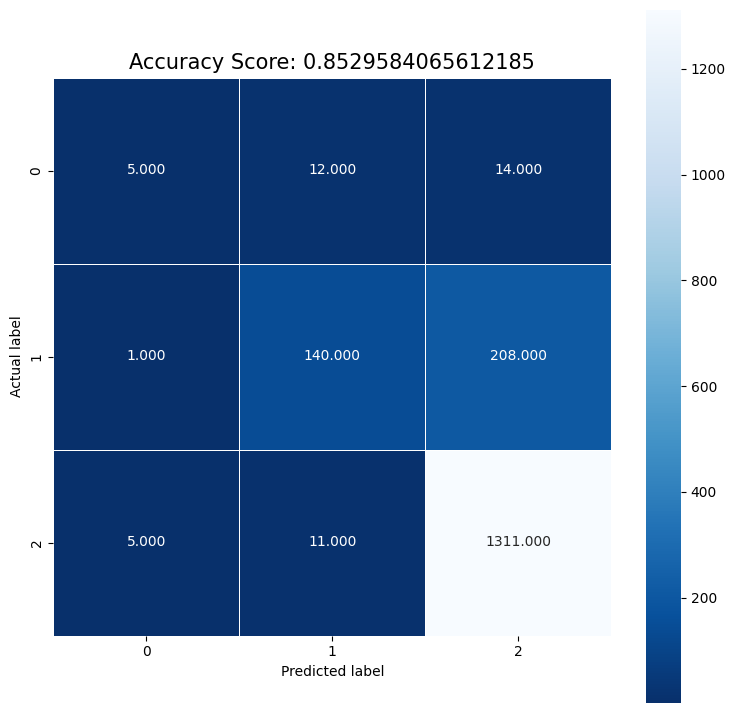

In [ ]:
# Accuracy Heat Map Visualization
y_pred = best_model.predict(x_test)
y_prob = best_model.predict_proba(x_test)
score = best_model.score(x_test, y_test)

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1 Score (macro): {f1_score(y_test, y_pred, average='macro')}")
print(f"ROC-AUC Score (macro): {roc_auc_score(y_test, y_prob, multi_class='ovr', average='macro')}")


cm = metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True, cmap = 'Blues_r')
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Accuracy Score: {0}'.format(score)
plt.title(all_sample_title, size = 15)

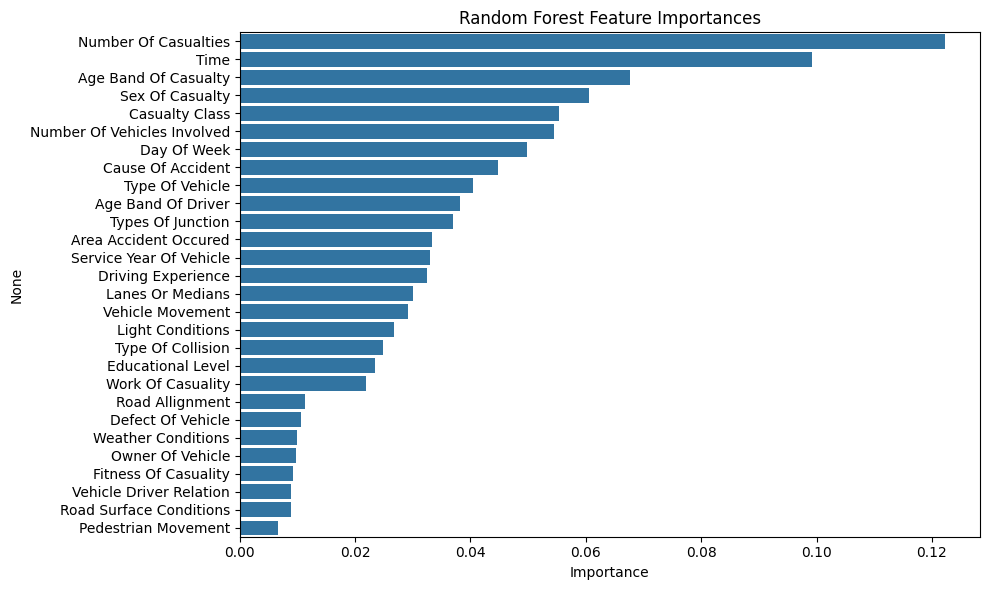

In [ ]:
# Feature Importance Bar Plot

# get importances and sort, format names
importances = best_model.feature_importances_
feat_imp = pd.Series(importances, index=selected_features).sort_values(ascending=False)
feat_imp.index = feat_imp.index.str.replace('_', ' ').str.title()

# plot
plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index)
plt.title("Random Forest Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

In [ ]:
classes = np.unique(y_test)
plt.figure(figsize=(8, 6))

for cls in classes:
    y_test_binary = (y_test == cls).astype(int)
    y_prob_cls = model.predict_proba(x_test)[:, cls]
    prob_true, prob_pred = calibration_curve(y_test_binary, y_prob_cls, n_bins=10, pos_label=1)
    plt.plot(prob_pred, prob_true, marker='o', linewidth=1, label=labelEncoder.classes_[cls])

plt.plot([0, 1], [0, 1], linestyle='--', label='Perfect Calibration')
plt.xlabel("Mean Predicted Probability")
plt.ylabel("Fraction of Positives")
plt.title("Calibration Plots for Each Class")
plt.legend()
plt.tight_layout()
plt.show()

NameError: name 'labelEncoder' is not defined

<Figure size 800x600 with 0 Axes>